## Value-at-Risk: Using Historical Simulation

**Functions**

`Series.quantile`, `Series.rolling`

### Exercise 58
Compute the 1-, 5- and 10-day historical simulation VaR for the S&P 500 and
the EUR/USD rate.

**Note**: Start the historical simulation at 25% of the data, and then build the
additional forecasts using a recursive scheme.

In [15]:
%matplotlib inline

import pandas as pd
sp500 = pd.read_hdf("./data/arch-data.h5", "sp500")
eurusd = pd.read_hdf("./data/arch-data.h5", "eurusd")

sp500_returns = 100 * sp500.SP500.pct_change().dropna()
eurusd_returns = 100 * eurusd.DEXUSEU.pct_change().dropna()

### Explanation

We start by loading the indices and transforming each into percentage returns.

In [16]:
start = int(sp500_returns.shape[0] * 0.25)
var_5_1day = -sp500_returns.expanding(min_periods=start).quantile(0.05)

### Explanation

pandas exposes an interface for `expanding` window statistics which is virtually
identical to the `rolling` window interface. The key parameter is `min_periods`
which sets the smallest sample that will be used.  A key feature of `expanding`
is that the statistic computed using observations $0$, $1$, $\ldots$, $m$ are
placed in position $m$. In code notation, `stat[m] = func(data[:(m+1)])`.  This
is important when forecasting since the value in position $m$ is the forecast
for `m+1`. We could use `shift` to move it forward 1 observation, which aligns the
forecast with its realization.

In [17]:
rets_5_day = sp500_returns.rolling(5).sum().dropna()
var_5_5day = -rets_5_day.expanding(min_periods=start).quantile(0.05)


### Explanation

To implement HS over longer horizons, we first need to compute the $h$-day return.
We construct the returns using `rolling(h).sum()`. Finally, we can use `expanding`
on the 5-day returns to compute the expanding set of quantiles. Again, these are
aligned at the point where the forecast is made, not where it is forecasting.

In [18]:
rets_10_day = sp500_returns.rolling(10).sum().dropna()
var_5_10day = -rets_10_day.expanding(min_periods=start).quantile(0.05)


### Explanation

The 10-day VaR is virtually identical, using `rolling` and then `expanding`.

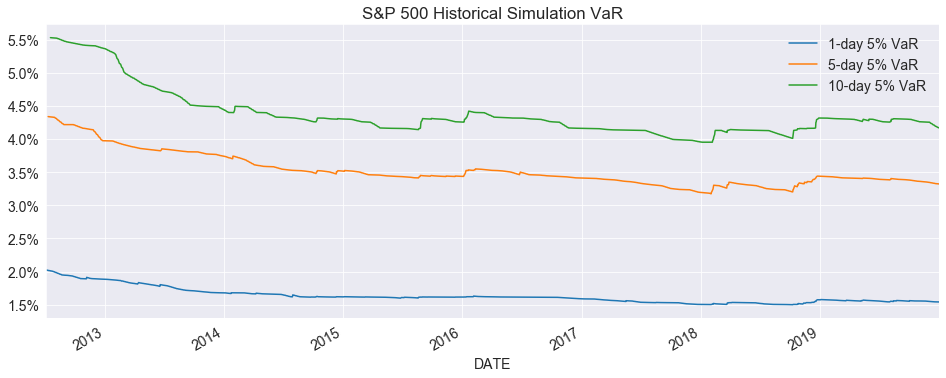

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
plt.rc("figure",figsize=(16,6))
plt.rc("font",size=14)

value_at_risks = pd.concat([var_5_1day, var_5_5day, var_5_10day], axis=1)
value_at_risks = value_at_risks.dropna(how="all")
value_at_risks.columns = ["1-day 5% VaR","5-day 5% VaR","10-day 5% VaR"]
ax = value_at_risks.plot(legend=False)
ax.set_yticklabels([f"{tick}%" for tick in ax.get_yticks()])
ax.set_title("S&P 500 Historical Simulation VaR")
lgd = plt.legend(frameon=False)


### Explanation

We can join the three VaRs into a single DataFrame and then plot them.

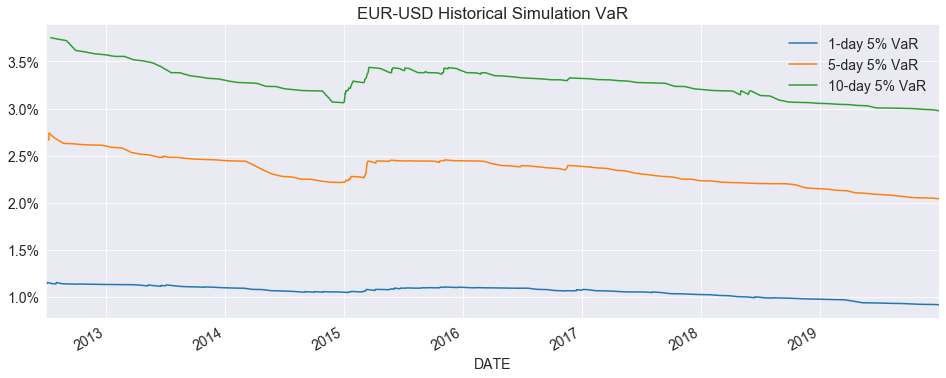

In [20]:
eurusd_value_at_risks = {}
for horizon in (1,5,10):
    multi_day_returns = eurusd_returns.rolling(horizon).sum().dropna()
    actual_var = multi_day_returns.expanding(min_periods=start).quantile(0.05)
    # Negate to make sure the VaR is positive
    eurusd_value_at_risks[f"{horizon}-day 5% VaR"] = -actual_var
eurusd_value_at_risks = pd.DataFrame(eurusd_value_at_risks).dropna(how="all")

ax = eurusd_value_at_risks.plot(legend=False)
ax.set_yticklabels([f"{tick}%" for tick in ax.get_yticks()])
ax.set_title("EUR-USD Historical Simulation VaR")
plt.legend(frameon=False)


### Explanation

We can use the same process to automate the process for the EUR/USD rate.
While it is wasteful to use `rolling(1)` for the 1-step VaR, uniformly
applying this method simplified the code. Finally, we can plot the series.

The function `ax.set_yticklabels` allows us to set the string labels
of the y-ticks, which we get with `ax.get_yticks`.

In [21]:
with pd.HDFStore("./data/hs-var.h5", mode="w") as hdf:
    hdf.put("sp500_var", value_at_risks)
    hdf.put("eurusd_var", eurusd_value_at_risks)